## 3DCNN model evalutaion

In [1]:
import pandas as pd
import joblib as jbl
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

## Sampling -> Magnification -> Optical Flow

### Split

In [2]:
def get_train_test_indeces(Y_path, shuffle: bool = True, test_size: float = None, combine_double_labels: bool = False, one_hot_emotions: bool = True):
    labels = pd.read_csv(Y_path, index_col="Unnamed: 0")
    labels["emotion"] = labels["emotion"].apply(lambda x: x.lower())
    mlb_df = pd.DataFrame()
    if "subject" in labels.columns:
        labels.drop("subject", axis=1, inplace=True)
    if combine_double_labels:
        map_dict = {
        'happiness': 'happiness',
        'positive': 'positive',
        'surprise+positive': 'positive', 
        'disgust': 'disgust',
        'negative': 'negative',
        'sadness': 'sadness',
        'surprise+negative': 'surprise',
        'repression': 'repression',
        'positive+repression': 'repression',
        'negative+repression': 'repression',
        'surprise+repression': 'repression',
        'surprise': 'surprise',
        'fear': 'others',  # rare
        'others': 'others'
        }
        labels['emotion'] = labels['emotion'].replace(map_dict)
    test_idx = None
    train_idx = None
    indeces = np.arange(len(labels))
    train_idx, test_idx =  train_test_split(indeces, test_size=test_size, stratify=labels['emotion'], shuffle=shuffle, random_state=341)
    if one_hot_emotions:
        mlb_df["emotion"]  = labels["emotion"].apply(lambda x: x.split("+"))
        mlb = MultiLabelBinarizer().fit(mlb_df["emotion"])
        transform = mlb.transform(mlb_df["emotion"])
        mlb_df[mlb.classes_] = transform
        mlb_df.drop("emotion", axis=1, inplace=True)
        return train_idx, test_idx, labels, mlb_df
    return train_idx, test_idx, labels

train_idx, test_idx, labels = get_train_test_indeces("../data/union+subject.csv", shuffle=True, test_size=0.2, one_hot_emotions=False, combine_double_labels=True)
display(labels.head(5))

,AU5,AU24,AU43,AU64,AU17,AU7,AU1,AU20,AU39,AU6,...,AU15,AU12,AU16,AU63,AU10,AU45,AU26,AU9,AU25,emotion
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,happiness
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,others
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,others
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,others
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,others


In [4]:
data_casme = jbl.load("../data/casme_mag_of.pkl")
print(data_casme.shape)
data_4dme = jbl.load("../data/4dme_mag_of.pkl")
print(data_4dme.shape)
concatted = np.concatenate([data_casme, data_4dme], axis=0)
print(concatted.shape)

(256, 7, 224, 224, 3)
(267, 7, 224, 224, 3)
(523, 7, 224, 224, 3)


In [5]:
labels["emotion"] = labels["emotion"].apply(lambda x: x.lower())
NUM_EMOTIONS = len(labels["emotion"].unique())
NUM_AUS = len(labels.columns[1:])
NUM_FRAMES = concatted.shape[1]
Y_SCALE = concatted.shape[2]
X_SCALE = concatted.shape[3]
CHANNELS = 1 if len(concatted.shape) <= 4 else concatted.shape[4]
le = LabelEncoder()
le.fit(labels["emotion"])
emotions = le.transform(labels["emotion"])
aus = labels[labels.columns[:-1]].to_numpy()
DATA_SIZE = concatted.shape[0]

We need to alter the class weights for emotions

In [6]:
emotion_counts = labels["emotion"].value_counts()
display(emotion_counts)
display(labels[labels.columns[:-1]].sum())
inverse_freq = 1 / emotion_counts.values
inverse_freq = 5 * (inverse_freq / np.max(inverse_freq))
codes = le.transform(emotion_counts.keys())
arg_sorted = np.argsort(codes)
class_weights = inverse_freq[arg_sorted]

emotion
others        132
negative      127
disgust        64
surprise       62
repression     51
positive       48
happiness      32
sadness         7
Name: count, dtype: int64

AU5      10
AU24     11
AU43      1
AU64      1
AU17     36
AU7     128
AU1      72
AU20      3
AU39      4
AU6      38
AU4     232
AU2      76
AU38      2
AU18      1
AU14     31
AU15     22
AU12     87
AU16      1
AU63      2
AU10     18
AU45     34
AU26      1
AU9      14
AU25      2
dtype: int64

In [6]:
training = tf.data.Dataset.from_tensor_slices((concatted[train_idx], (emotions[train_idx], aus[train_idx]))).shuffle(buffer_size=len(train_idx), seed=255).batch(1).prefetch(tf.data.AUTOTUNE)
validation = tf.data.Dataset.from_tensor_slices((concatted[test_idx], (emotions[test_idx], aus[test_idx]))).batch(1).prefetch(tf.data.AUTOTUNE)
'''
dataset = tf.data.Dataset.from_tensor_slices((concatted, (emotions, aus))).shuffle(buffer_size=DATA_SIZE, seed = 255).batch(1)
validation = dataset.skip(int(DATA_SIZE*0.65)).prefetch(tf.data.AUTOTUNE)
training = dataset.take(int(DATA_SIZE*0.65)).prefetch(tf.data.AUTOTUNE)
'''

'\ndataset = tf.data.Dataset.from_tensor_slices((concatted, (emotions, aus))).shuffle(buffer_size=DATA_SIZE, seed = 255).batch(1)\nvalidation = dataset.skip(int(DATA_SIZE*0.65)).prefetch(tf.data.AUTOTUNE)\ntraining = dataset.take(int(DATA_SIZE*0.65)).prefetch(tf.data.AUTOTUNE)\n'

In [7]:
class_weights = tf.cast(tf.constant(class_weights), dtype=tf.float32)

def weighted_loss(y_true, y_pred):
    weight = tf.gather(class_weights, y_true)
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    return loss * weight

def basic_block(inputs, filters, stride=(1,1,1)):

    x = tf.keras.layers.Conv3D(filters, (3,3,3), strides=stride, padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv3D(filters, (1,3,3), strides=1, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)

    shortcut = inputs
    if stride != (1,1,1) or inputs.shape[-1] != filters:
        shortcut = tf.keras.layers.Conv3D(filters, (3,3,3), strides=stride, padding="same")(inputs)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)

    x = tf.keras.layers.Add()([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)
    return x

def make_blocks(inputs, filters, blocks, stride=(1,1,1)):
    x = basic_block(inputs, filters, stride=stride)
    for _ in range(1, blocks):
        x = basic_block(x, filters, stride=(1,1,1))
    return x

def video_encoder(input_shape=(8,224,224,3), pooling='avg'):
    video_in = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Conv3D(8, (3,7,7), strides=(1,2,2), padding="same")(video_in)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.SpatialDropout3D(0.2)(x)
    x = tf.keras.layers.MaxPooling3D((1,3,3), strides=(1,2,2), padding="same")(x)
    x = tf.keras.layers.Conv3D(16, (3,5,5), strides=(1,2,2), padding="same", activation="relu")(x)
    # spatiotemporal compression
    x = make_blocks(x, 32, blocks=1, stride=2)
    x = make_blocks(x, 64, blocks=1, stride=2)
    x = make_blocks(x, 128, blocks=1, stride =2)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Conv3D(256, (1,3,3), strides=1, padding="same", activation="relu")(x) #kernel_regularizer=tf.keras.regularizers.l2(0.01)
    x = tf.keras.layers.MaxPool3D((1,3,3), strides=(1,2,2), padding="same")(x)
    x = tf.keras.layers.Dropout(0.45)(x)

    if pooling == 'avg':
        x = tf.keras.layers.GlobalAveragePooling3D()(x)
    elif pooling == 'max':
        x = tf.keras.layers.GlobalMaxPooling3D()(x)
    else:
        x = tf.keras.layers.Flatten()(x)

    model = tf.keras.Model(video_in, x)
    return model

def build_3d_cnn(input_shape=(8, 112, 112, 1), num_emotions=7, num_aus=12, lstm_hidden=128, dropout_f = 0.5):

    T, H, W, C = input_shape
    video_in = tf.keras.layers.Input(shape=input_shape, name="video_in")  # (T, H, W, C)
    encoder = video_encoder(input_shape=(T, H,W,C), pooling=None)
    dropout = tf.keras.layers.Dropout(dropout_f)(encoder(video_in))
    dense = tf.keras.layers.Dense(lstm_hidden, activation="relu")(dropout)
    emotion_logits = tf.keras.layers.Dense(num_emotions, name="emotion_logits", activation="softmax")(dense)
    au_logits = tf.keras.layers.Dense(num_aus, name="au_logits", activation="sigmoid")(dense)

    model = tf.keras.Model(inputs=video_in, outputs=[emotion_logits, au_logits], name="3D_CNN") # au_logits]
    return model

#1.2kk parameters, showed 65% validation on motion magnification

Model: "3D_CNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 video_in (InputLayer)          [(None, 7, 224, 224  0           []                               
                                , 3)]                                                             
                                                                                                  
 model (Functional)             (None, 1024)         1085856     ['video_in[0][0]']               
                                                                                                  
 dropout_2 (Dropout)            (None, 1024)         0           ['model[0][0]']                  
                                                                                                  
 dense (Dense)                  (None, 128)          131200      ['dropout_2[0][0]']         

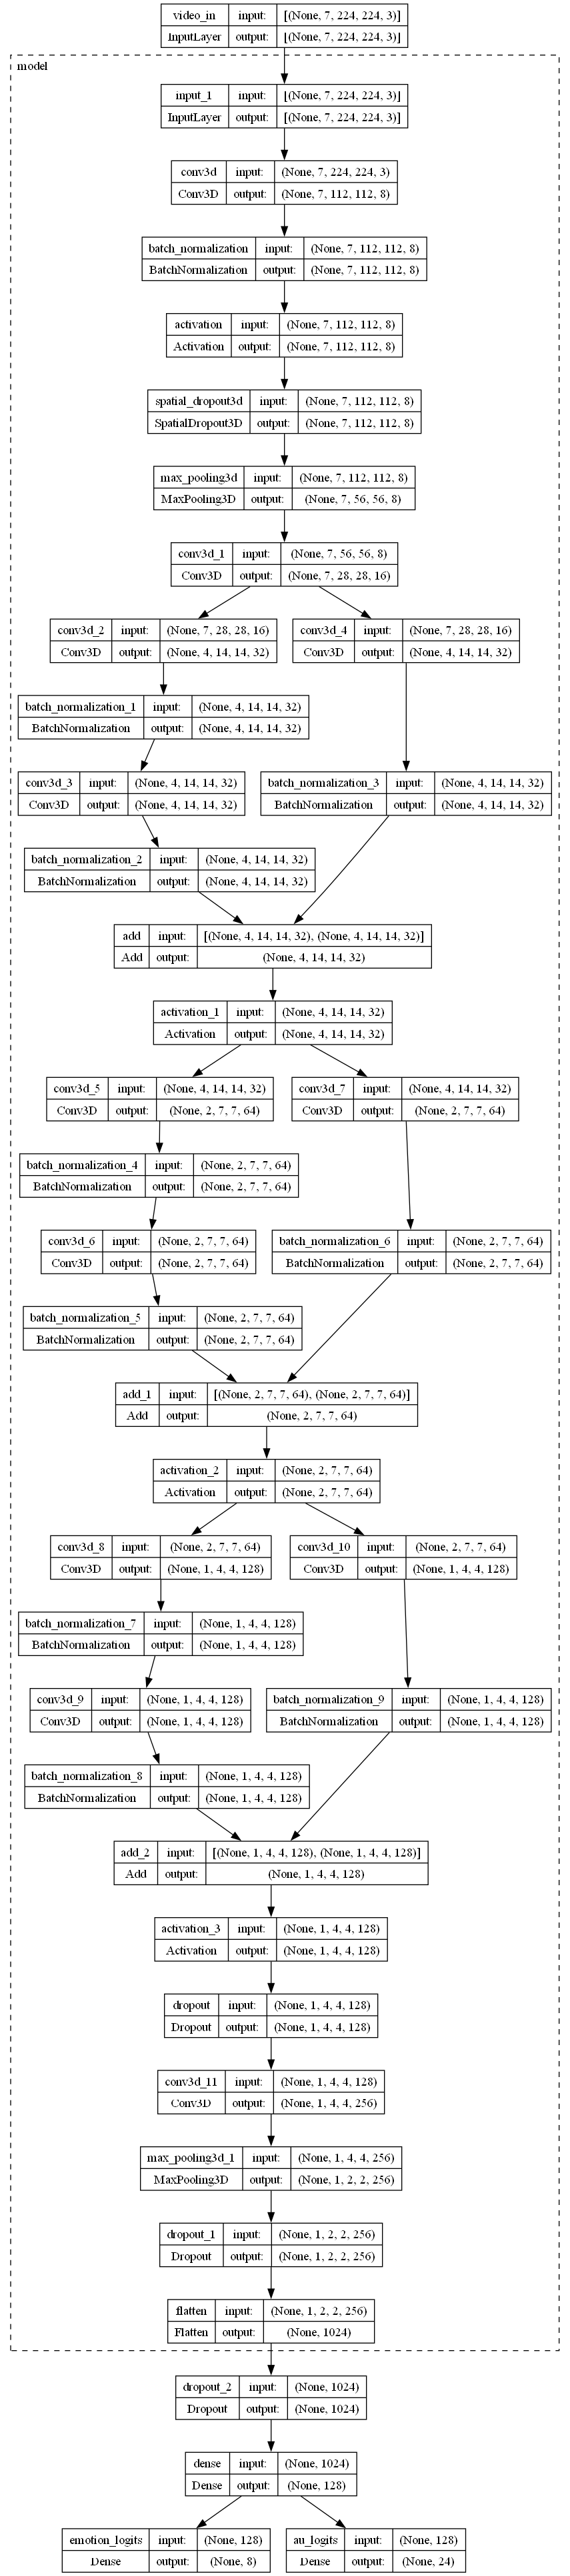

In [8]:
model = build_3d_cnn(input_shape=(NUM_FRAMES, Y_SCALE, X_SCALE, CHANNELS), num_emotions=NUM_EMOTIONS, num_aus=NUM_AUS)
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True,expand_nested=True)

### Using Focal Loss due to sparsity of AU vectors

In [9]:
EPOCHS = 30
def decay(epoch, lr):
    if epoch == 27:
        return lr * 0.1
    return lr

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_emotion_logits_loss',
    factor=0.1,      
    patience=4,       
    min_lr=1e-6,      
    verbose=1
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss={
        "emotion_logits": weighted_loss,
        "au_logits": tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True, gamma = 2) #tf.keras.losses.BinaryCrossentropy(from_logits=False)
    },
    metrics={
        "emotion_logits": tf.keras.metrics.SparseCategoricalAccuracy(),
         "au_logits": tf.keras.metrics.AUC(multi_label=True)
    },
    loss_weights={"emotion_logits": 1.0,
                  "au_logits": 2.0
     },
)
history = model.fit(training, validation_data=validation, epochs = EPOCHS, verbose=1)#, callbacks=lr_scheduler)

Epoch 1/30
418/418 [==============================] - 28s 35ms/step - loss: 2.0314 - emotion_logits_loss: 1.6780 - au_logits_loss: 0.1767 - emotion_logits_sparse_categorical_accuracy: 0.1172 - au_logits_auc: 0.5217 - val_loss: 1.1740 - val_emotion_logits_loss: 1.0760 - val_au_logits_loss: 0.0490 - val_emotion_logits_sparse_categorical_accuracy: 0.2286 - val_au_logits_auc: 0.3512
Epoch 2/30
418/418 [==============================] - 13s 30ms/step - loss: 1.5913 - emotion_logits_loss: 1.4670 - au_logits_loss: 0.0622 - emotion_logits_sparse_categorical_accuracy: 0.1483 - au_logits_auc: 0.5200 - val_loss: 1.1335 - val_emotion_logits_loss: 1.0625 - val_au_logits_loss: 0.0355 - val_emotion_logits_sparse_categorical_accuracy: 0.2381 - val_au_logits_auc: 0.3814
Epoch 3/30
418/418 [==============================] - 12s 30ms/step - loss: 1.4376 - emotion_logits_loss: 1.3403 - au_logits_loss: 0.0486 - emotion_logits_sparse_categorical_accuracy: 0.1459 - au_logits_auc: 0.4187 - val_loss: 1.1695 - 

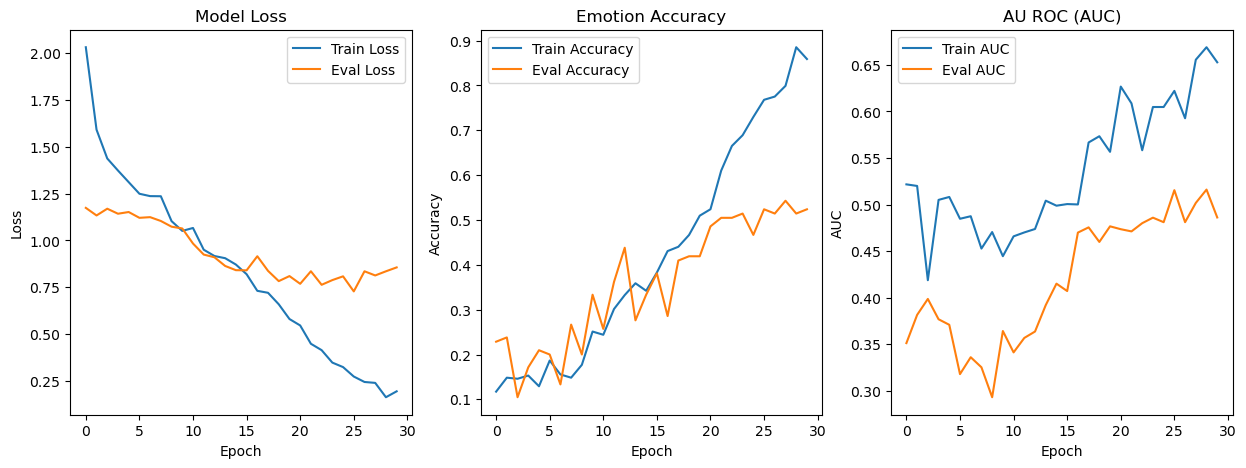

              precision    recall  f1-score   support

         AU5        nan      0.00      0.00         2
        AU24        nan      0.00      0.00         1
        AU43        nan       nan       nan         0
        AU64        nan       nan       nan         0
        AU17       1.00      0.12      0.22         8
         AU7       0.00      0.00      0.00        26
         AU1       0.75      0.40      0.52        15
        AU20        nan      0.00      0.00         1
        AU39        nan       nan       nan         0
         AU6        nan      0.00      0.00         4
         AU4       0.86      0.65      0.74        48
         AU2       0.83      0.67      0.74        15
        AU38        nan      0.00      0.00         1
        AU18        nan       nan       nan         0
        AU14        nan      0.00      0.00         5
        AU15       0.00      0.00      0.00         2
        AU12       1.00      0.20      0.33        15
        AU16        nan    

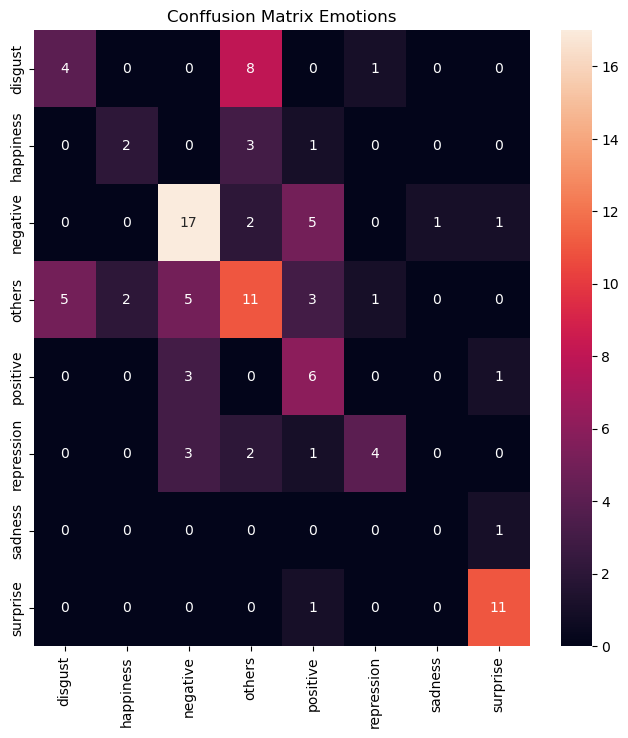

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def results(history, prefix = ""):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    emotion_train_accuracy = history.history['emotion_logits_sparse_categorical_accuracy']
    emotion_val_accuracy =  history.history['val_emotion_logits_sparse_categorical_accuracy']
    au_train_accuracy =  history.history['au_logits_auc'+ prefix]
    au_val_accuracy =  history.history['val_au_logits_auc'+ prefix]

    def plot_history(data_1, data_2, label, subplot, title):
        x = np.arange(EPOCHS)
        plt.subplot(1, 3, subplot)
        plt.plot(x, data_1, label = f"Train {label}")
        plt.plot(x, data_2, label = f"Eval {label}")
        plt.xlabel("Epoch")
        plt.ylabel(label)
        plt.legend()
        plt.title(title)

    plt.figure(figsize = (15, 5))
    plot_history(loss, val_loss, "Loss", 1, "Model Loss")
    plot_history(emotion_train_accuracy, emotion_val_accuracy, "Accuracy", 2, "Emotion Accuracy")
    plot_history(au_train_accuracy, au_val_accuracy, "AUC", 3, "AU ROC (AUC)")
    plt.show()

results(history, "")
def eval_model(validation_data, model):
    true_emotions = []
    true_AUs = []
    pred_emotions = []
    pred_AUs = []
    count = 0
    for video, (emotion, au_vector) in validation_data:
        count += 1
        true_emotions.append(emotion.numpy().squeeze())
        true_AUs.append(au_vector.numpy().squeeze())
        pred = model.predict(video, verbose = 0)
        pred_emotions.append(np.argmax(pred[0]))
        pred_AUs.append((pred[1] > 0.5).astype(np.int32).squeeze())
    cr_aus = classification_report(true_AUs, pred_AUs, target_names = labels.columns[:-1], zero_division=np.nan)
    pred_emotions = le.inverse_transform(pred_emotions)
    true_emotions = le.inverse_transform(true_emotions)
    cr_emotions = classification_report(true_emotions, pred_emotions)
    cm_emotions = confusion_matrix(true_emotions, pred_emotions)
    print(cr_aus)
    print(cr_emotions)
    plt.figure(figsize=(8,8))
    target_names_emotions =  np.unique(true_emotions)
    sns.heatmap(cm_emotions, annot=True, fmt= "d", xticklabels=target_names_emotions, yticklabels=target_names_emotions)
    plt.title("Conffusion Matrix Emotions")
    plt.show()

eval_model(validation, model)

## Sample -> Optical Flow

In [11]:
data_casme = jbl.load("../data/casme_optical_only.pkl")
print(data_casme.shape)
data_4dme = jbl.load("../data/4dme_optical_only.pkl")
print(data_4dme.shape)
concatted = np.concatenate([data_casme, data_4dme], axis=0)
print(concatted.shape)
NUM_FRAMES = concatted.shape[1]
Y_SCALE = concatted.shape[2]
X_SCALE = concatted.shape[3]
CHANNELS = 1 if len(concatted.shape) <= 4 else concatted.shape[4]

(256, 7, 224, 224, 3)
(267, 7, 224, 224, 3)
(523, 7, 224, 224, 3)


In [12]:
training = tf.data.Dataset.from_tensor_slices((concatted[train_idx], (emotions[train_idx], aus[train_idx]))).shuffle(buffer_size=len(train_idx), seed=255).batch(1).prefetch(tf.data.AUTOTUNE)
validation = tf.data.Dataset.from_tensor_slices((concatted[test_idx], (emotions[test_idx], aus[test_idx]))).batch(1).prefetch(tf.data.AUTOTUNE)
'''
dataset = tf.data.Dataset.from_tensor_slices((concatted, (emotions, aus))).shuffle(buffer_size=DATA_SIZE, seed = 255).batch(1)
validation = dataset.skip(int(DATA_SIZE*0.65)).prefetch(tf.data.AUTOTUNE)
training = dataset.take(int(DATA_SIZE*0.65)).prefetch(tf.data.AUTOTUNE)
'''

'\ndataset = tf.data.Dataset.from_tensor_slices((concatted, (emotions, aus))).shuffle(buffer_size=DATA_SIZE, seed = 255).batch(1)\nvalidation = dataset.skip(int(DATA_SIZE*0.65)).prefetch(tf.data.AUTOTUNE)\ntraining = dataset.take(int(DATA_SIZE*0.65)).prefetch(tf.data.AUTOTUNE)\n'

In [13]:
model = build_3d_cnn(input_shape=(NUM_FRAMES, Y_SCALE, X_SCALE, CHANNELS), num_emotions=NUM_EMOTIONS, num_aus=NUM_AUS)
def decay(epoch, lr):
    if epoch == 20:
        return lr / 5
    return lr

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss={
        "emotion_logits": weighted_loss,
        "au_logits": tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True) #target AU binary vectors are way too sparse, so this loss compensates this
    },
    metrics={
        "emotion_logits": tf.keras.metrics.SparseCategoricalAccuracy(),
         "au_logits": tf.keras.metrics.AUC(multi_label=True)
    },
    loss_weights={"emotion_logits": 1.0, "au_logits": 2.0
     },
)
history = model.fit(training, validation_data=validation, epochs = EPOCHS, verbose=1, callbacks = tf.keras.callbacks.LearningRateScheduler(decay))
model.save("optical_flow_train_test.h5")

Epoch 1/30
418/418 [==============================] - 18s 32ms/step - loss: 2.2286 - emotion_logits_loss: 1.9288 - au_logits_loss: 0.1499 - emotion_logits_sparse_categorical_accuracy: 0.1268 - au_logits_auc_1: 0.4674 - val_loss: 1.1730 - val_emotion_logits_loss: 1.1016 - val_au_logits_loss: 0.0357 - val_emotion_logits_sparse_categorical_accuracy: 0.1333 - val_au_logits_auc_1: 0.3667 - lr: 1.0000e-04
Epoch 2/30
418/418 [==============================] - 12s 29ms/step - loss: 1.6500 - emotion_logits_loss: 1.5382 - au_logits_loss: 0.0559 - emotion_logits_sparse_categorical_accuracy: 0.1220 - au_logits_auc_1: 0.4503 - val_loss: 1.1436 - val_emotion_logits_loss: 1.0739 - val_au_logits_loss: 0.0349 - val_emotion_logits_sparse_categorical_accuracy: 0.1429 - val_au_logits_auc_1: 0.3405 - lr: 1.0000e-04
Epoch 3/30
418/418 [==============================] - 13s 32ms/step - loss: 1.3705 - emotion_logits_loss: 1.2810 - au_logits_loss: 0.0447 - emotion_logits_sparse_categorical_accuracy: 0.1603 - a

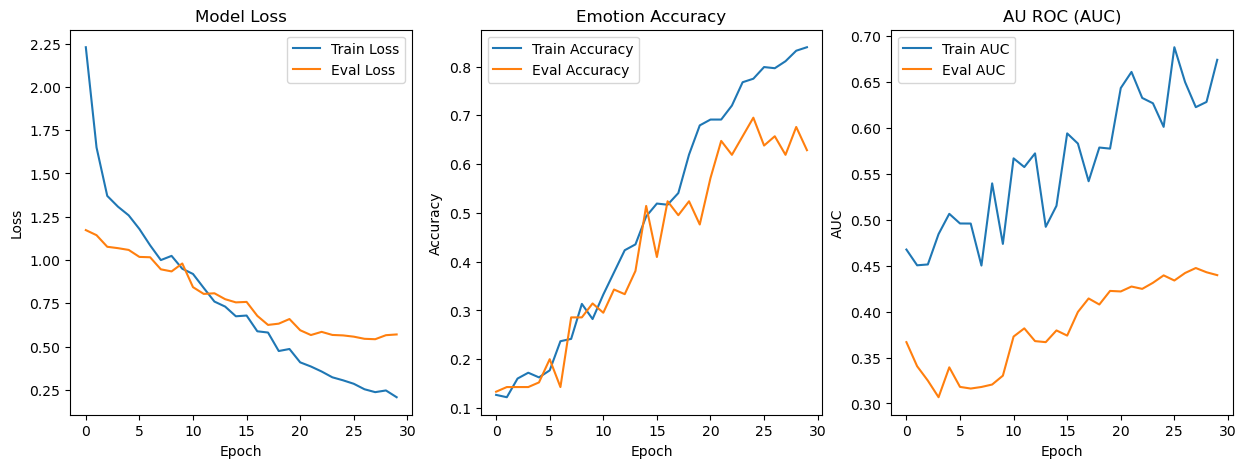

c:\Users\Leonid\anaconda3\envs\dlearn_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Leonid\anaconda3\envs\dlearn_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Leonid\anaconda3\envs\dlearn_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

              precision    recall  f1-score   support

         AU5        nan      0.00      0.00         2
        AU24        nan      0.00      0.00         1
        AU43        nan       nan       nan         0
        AU64        nan       nan       nan         0
        AU17        nan      0.00      0.00         8
         AU7        nan      0.00      0.00        26
         AU1       1.00      0.67      0.80        15
        AU20        nan      0.00      0.00         1
        AU39        nan       nan       nan         0
         AU6        nan      0.00      0.00         4
         AU4       0.94      0.69      0.80        48
         AU2       0.60      0.20      0.30        15
        AU38        nan      0.00      0.00         1
        AU18        nan       nan       nan         0
        AU14        nan      0.00      0.00         5
        AU15        nan      0.00      0.00         2
        AU12        nan      0.00      0.00        15
        AU16        nan    

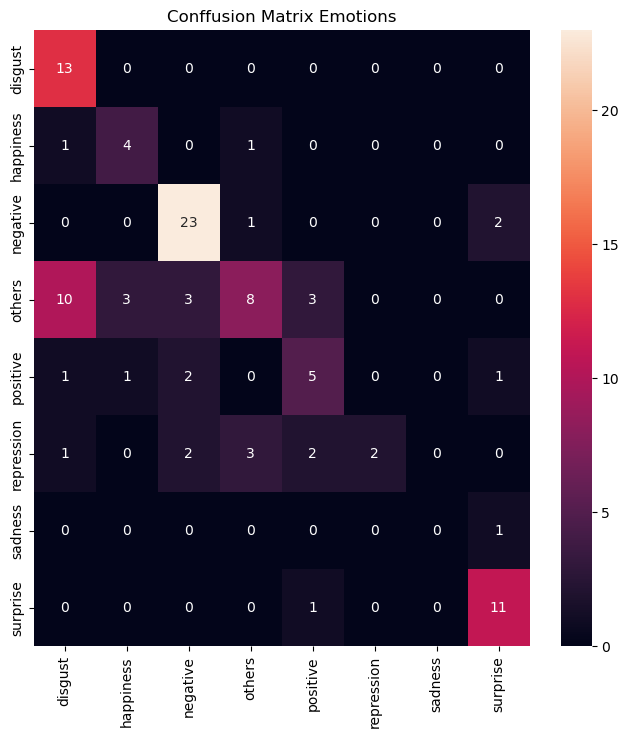

In [14]:
results(history, prefix = "_1")
eval_model(validation, model)

## Magnification -> Sample

In [15]:
data_casme = jbl.load("../data/casme_magnify_only.pkl")
print(data_casme.shape)
data_4dme = jbl.load("../data/4dme_magnify_only.pkl")
print(data_4dme.shape)
concatted = np.concatenate([data_casme, data_4dme], axis=0)
print(concatted.shape)
NUM_FRAMES = concatted.shape[1]
Y_SCALE = concatted.shape[2]
X_SCALE = concatted.shape[3]
CHANNELS = 1 if len(concatted.shape) <= 4 else concatted.shape[4]

(256, 8, 224, 224)
(267, 8, 224, 224)
(523, 8, 224, 224)


In [16]:
training = tf.data.Dataset.from_tensor_slices((concatted[train_idx], (emotions[train_idx], aus[train_idx]))).shuffle(buffer_size=len(train_idx), seed=255).batch(1).prefetch(tf.data.AUTOTUNE)
validation = tf.data.Dataset.from_tensor_slices((concatted[test_idx], (emotions[test_idx], aus[test_idx]))).batch(1).prefetch(tf.data.AUTOTUNE)
'''
dataset = tf.data.Dataset.from_tensor_slices((concatted, (emotions, aus))).shuffle(buffer_size=DATA_SIZE, seed = 255).batch(1)
validation = dataset.skip(int(DATA_SIZE*0.65)).prefetch(tf.data.AUTOTUNE)
training = dataset.take(int(DATA_SIZE*0.65)).prefetch(tf.data.AUTOTUNE)
'''

'\ndataset = tf.data.Dataset.from_tensor_slices((concatted, (emotions, aus))).shuffle(buffer_size=DATA_SIZE, seed = 255).batch(1)\nvalidation = dataset.skip(int(DATA_SIZE*0.65)).prefetch(tf.data.AUTOTUNE)\ntraining = dataset.take(int(DATA_SIZE*0.65)).prefetch(tf.data.AUTOTUNE)\n'

In [ ]:
model = build_3d_cnn(input_shape=(NUM_FRAMES, Y_SCALE, X_SCALE, CHANNELS), num_emotions=NUM_EMOTIONS, num_aus=NUM_AUS)
EPOCHS = 35
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss={
        "emotion_logits": weighted_loss,
        "au_logits": tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True) #tf.keras.losses.BinaryCrossentropy(from_logits=False)
    },
    metrics={
        "emotion_logits": tf.keras.metrics.SparseCategoricalAccuracy(),
         "au_logits": tf.keras.metrics.AUC(multi_label=True)
    },
    loss_weights={"emotion_logits": 1.0, "au_logits": 2.0
     },
)
history = model.fit(training, validation_data=validation, epochs = EPOCHS, verbose=1)#, callbacks=lr_scheduler)

Epoch 1/35
418/418 [==============================] - 16s 30ms/step - loss: 2.1045 - emotion_logits_loss: 1.7480 - au_logits_loss: 0.1782 - emotion_logits_sparse_categorical_accuracy: 0.1244 - au_logits_auc_2: 0.4688 - val_loss: 1.1411 - val_emotion_logits_loss: 1.0306 - val_au_logits_loss: 0.0552 - val_emotion_logits_sparse_categorical_accuracy: 0.2571 - val_au_logits_auc_2: 0.3754
Epoch 2/35
418/418 [==============================] - 11s 27ms/step - loss: 1.4910 - emotion_logits_loss: 1.3771 - au_logits_loss: 0.0570 - emotion_logits_sparse_categorical_accuracy: 0.1483 - au_logits_auc_2: 0.4391 - val_loss: 1.0374 - val_emotion_logits_loss: 0.9765 - val_au_logits_loss: 0.0304 - val_emotion_logits_sparse_categorical_accuracy: 0.3810 - val_au_logits_auc_2: 0.3661
Epoch 3/35
418/418 [==============================] - 11s 27ms/step - loss: 1.2905 - emotion_logits_loss: 1.2037 - au_logits_loss: 0.0434 - emotion_logits_sparse_categorical_accuracy: 0.2249 - au_logits_auc_2: 0.4709 - val_loss:

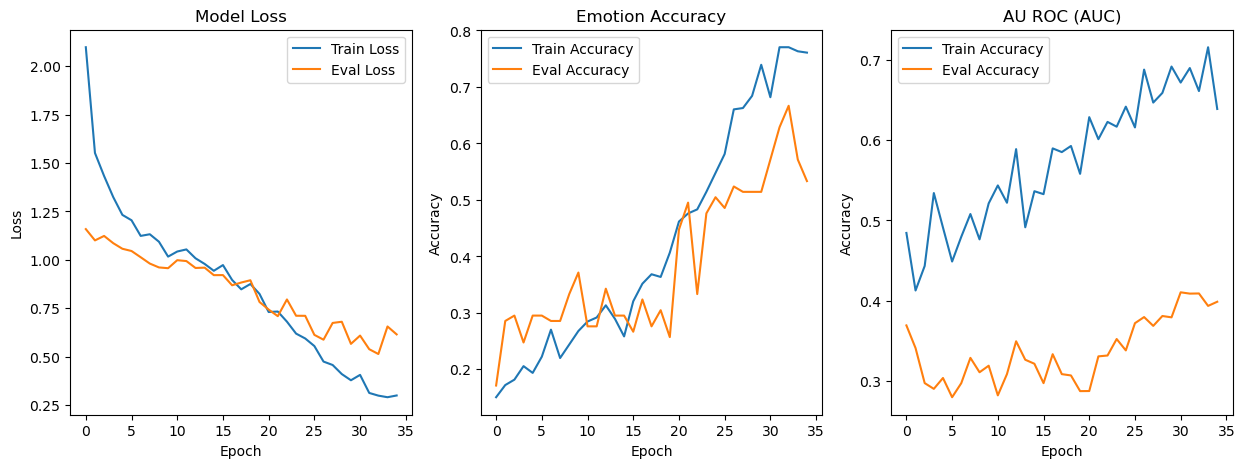

              precision    recall  f1-score   support

         AU5        nan      0.00      0.00         2
        AU24        nan      0.00      0.00         1
        AU43        nan       nan       nan         0
        AU64        nan       nan       nan         0
        AU17        nan      0.00      0.00         8
         AU7        nan      0.00      0.00        26
         AU1       0.43      0.20      0.27        15
        AU20        nan      0.00      0.00         1
        AU39        nan       nan       nan         0
         AU6        nan      0.00      0.00         4
         AU4       0.93      0.27      0.42        48
         AU2       0.80      0.27      0.40        15
        AU38        nan      0.00      0.00         1
        AU18        nan       nan       nan         0
        AU14        nan      0.00      0.00         5
        AU15        nan      0.00      0.00         2
        AU12       0.56      0.33      0.42        15
        AU16        nan    

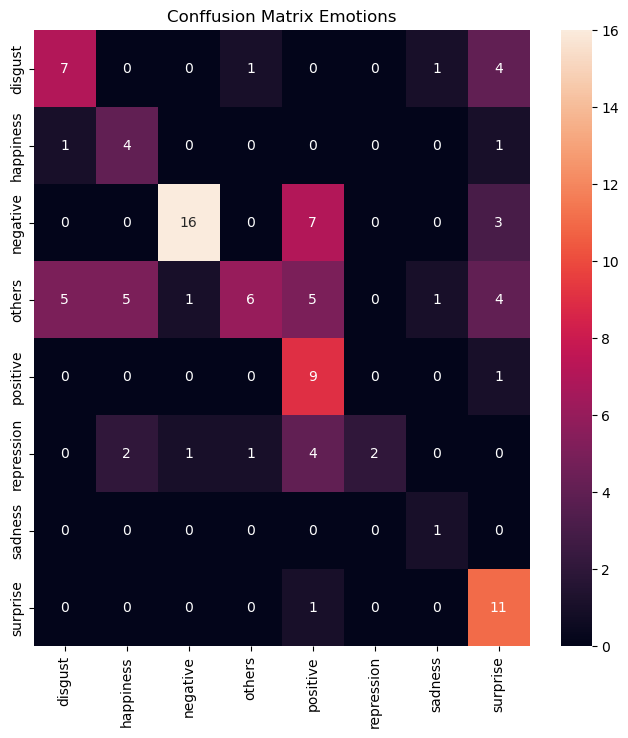

In [ ]:
results(history, prefix = "_2")
eval_model(validation, model)
model.save("magnification_train_test.h5")

## Early fusion of Optical flow + LBP

LBPs were computed after magnification and sampling, Optical flow after directly after sampling.

In [ ]:
of_casme = jbl.load("../data/casme_optical_only.pkl")
print(of_casme.shape)
of_4dme = jbl.load("../data/4dme_optical_only.pkl")
print(of_4dme.shape)
lbp_casme = jbl.load("../data/casme_magnified_lbps.pkl")
print(lbp_casme.shape)
lbp_4dme = jbl.load("../data/4dme_magnified_lbps.pkl")
print(lbp_4dme.shape)
data_casme = np.concatenate([of_casme, lbp_casme[:, :-1,..., np.newaxis]], axis=-1)
data_4dme = np.concatenate([of_4dme, lbp_4dme[:, :-1,..., np.newaxis]], axis=-1)
concatted = np.concatenate([data_casme, data_4dme], axis=0)
print(concatted.shape)
NUM_FRAMES = concatted.shape[1]
Y_SCALE = concatted.shape[2]
X_SCALE = concatted.shape[3]
CHANNELS = 1 if len(concatted.shape) <= 4 else concatted.shape[4]

(256, 7, 224, 224, 3)
(267, 7, 224, 224, 3)
(256, 8, 224, 224)
(267, 8, 224, 224)
(523, 7, 224, 224, 4)


In [ ]:
del data_casme
del data_4dme
del of_4dme 
del of_casme
del lbp_casme 
del lbp_4dme

In [ ]:
training = tf.data.Dataset.from_tensor_slices((concatted[train_idx], (emotions[train_idx], aus[train_idx]))).shuffle(buffer_size=len(train_idx), seed=255).batch(1).prefetch(tf.data.AUTOTUNE)
validation = tf.data.Dataset.from_tensor_slices((concatted[test_idx], (emotions[test_idx], aus[test_idx]))).batch(1).prefetch(tf.data.AUTOTUNE)
'''
dataset = tf.data.Dataset.from_tensor_slices((concatted, (emotions, aus))).shuffle(buffer_size=DATA_SIZE, seed = 255).batch(1)
validation = dataset.skip(int(DATA_SIZE*0.65)).prefetch(tf.data.AUTOTUNE)
training = dataset.take(int(DATA_SIZE*0.65)).prefetch(tf.data.AUTOTUNE)
'''

'\ndataset = tf.data.Dataset.from_tensor_slices((concatted, (emotions, aus))).shuffle(buffer_size=DATA_SIZE, seed = 255).batch(1)\nvalidation = dataset.skip(int(DATA_SIZE*0.65)).prefetch(tf.data.AUTOTUNE)\ntraining = dataset.take(int(DATA_SIZE*0.65)).prefetch(tf.data.AUTOTUNE)\n'

In [ ]:
model = build_3d_cnn(input_shape=(NUM_FRAMES, Y_SCALE, X_SCALE, CHANNELS), num_emotions=NUM_EMOTIONS, num_aus=NUM_AUS)
EPOCHS = 30
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss={
        "emotion_logits": weighted_loss,
        "au_logits": tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True) #tf.keras.losses.BinaryCrossentropy(from_logits=False)
    },
    metrics={
        "emotion_logits": tf.keras.metrics.SparseCategoricalAccuracy(),
         "au_logits": tf.keras.metrics.AUC(multi_label=True)
    },
    loss_weights={"emotion_logits": 1.0, "au_logits": 2.0
     },
)
history = model.fit(training, validation_data=validation, epochs = EPOCHS, verbose=1)#, callbacks = lr_scheduler)

Epoch 1/30
418/418 [==============================] - 18s 35ms/step - loss: 2.0502 - emotion_logits_loss: 1.6589 - au_logits_loss: 0.1957 - emotion_logits_sparse_categorical_accuracy: 0.1507 - au_logits_auc_3: 0.4933 - val_loss: 1.1666 - val_emotion_logits_loss: 1.0743 - val_au_logits_loss: 0.0462 - val_emotion_logits_sparse_categorical_accuracy: 0.1238 - val_au_logits_auc_3: 0.3797
Epoch 2/30
418/418 [==============================] - 13s 32ms/step - loss: 1.5231 - emotion_logits_loss: 1.3988 - au_logits_loss: 0.0621 - emotion_logits_sparse_categorical_accuracy: 0.1555 - au_logits_auc_3: 0.5444 - val_loss: 1.1754 - val_emotion_logits_loss: 1.1068 - val_au_logits_loss: 0.0343 - val_emotion_logits_sparse_categorical_accuracy: 0.1905 - val_au_logits_auc_3: 0.3618
Epoch 3/30
418/418 [==============================] - 13s 31ms/step - loss: 1.3932 - emotion_logits_loss: 1.3022 - au_logits_loss: 0.0455 - emotion_logits_sparse_categorical_accuracy: 0.1531 - au_logits_auc_3: 0.4589 - val_loss:

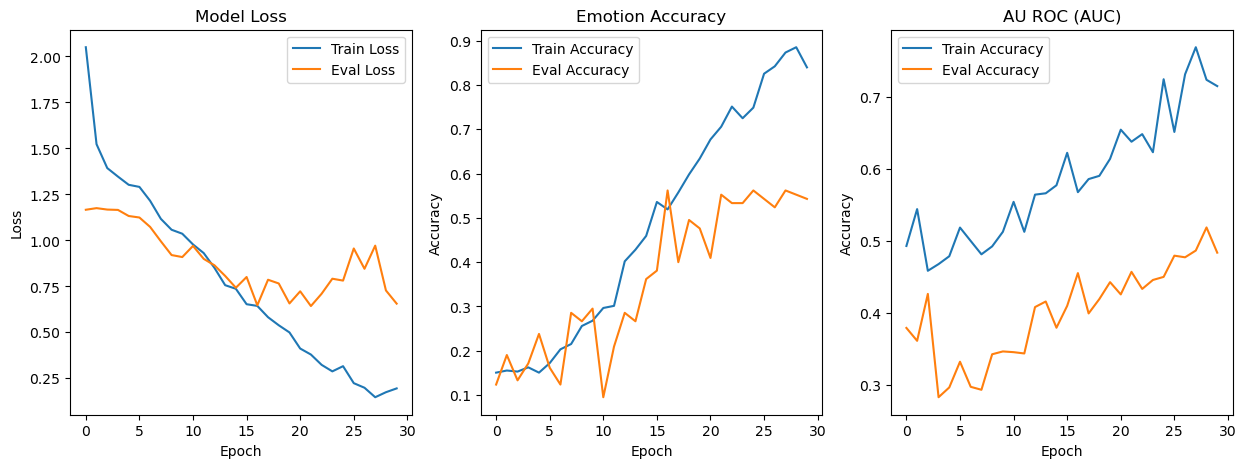

              precision    recall  f1-score   support

         AU5        nan      0.00      0.00         2
        AU24        nan      0.00      0.00         1
        AU43        nan       nan       nan         0
        AU64        nan       nan       nan         0
        AU17        nan      0.00      0.00         8
         AU7        nan      0.00      0.00        26
         AU1       0.88      0.47      0.61        15
        AU20        nan      0.00      0.00         1
        AU39        nan       nan       nan         0
         AU6        nan      0.00      0.00         4
         AU4       0.91      0.42      0.57        48
         AU2       0.78      0.47      0.58        15
        AU38        nan      0.00      0.00         1
        AU18        nan       nan       nan         0
        AU14        nan      0.00      0.00         5
        AU15        nan      0.00      0.00         2
        AU12       0.67      0.13      0.22        15
        AU16        nan    

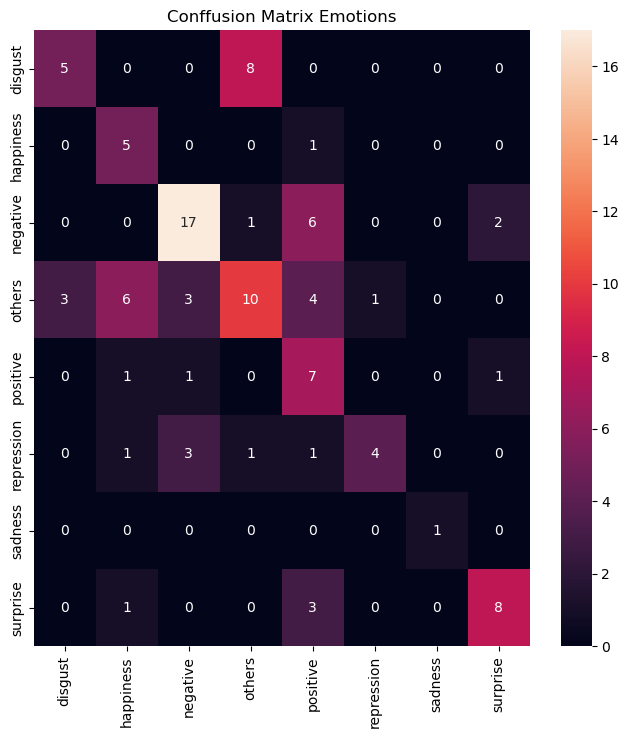

In [ ]:
results(history, prefix = "_3")
eval_model(validation, model)